# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.290464,False,1.450096
1,0.168962,True,5.720268
2,0.172375,True,5.832677
3,-0.923785,True,2.636808
4,0.067448,False,0.005195
...,...,...,...
995,-0.656897,True,5.879921
996,-0.727386,False,0.026675
997,0.276879,False,0.168830
998,-1.801114,False,-2.052688


<Axes: xlabel='v0'>

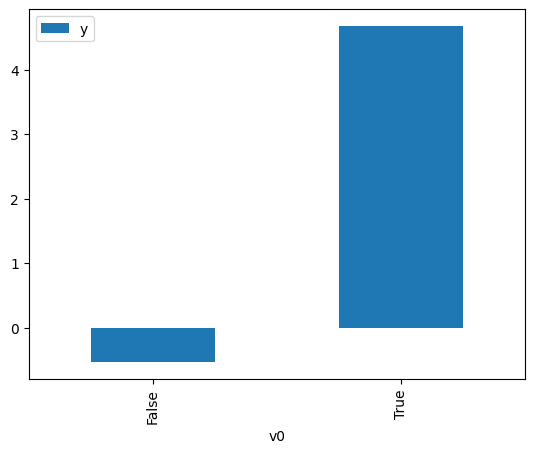

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

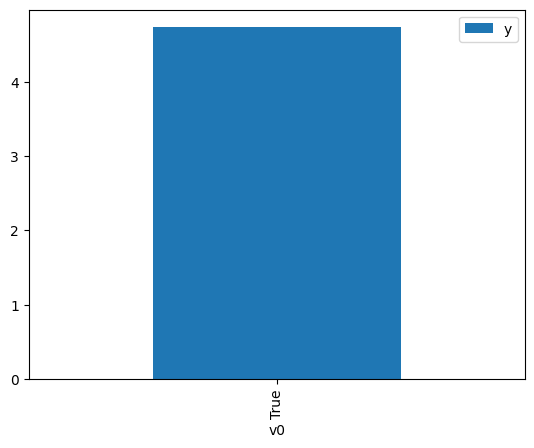

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.320613,False,-1.429671,0.314238,3.182305
1,-0.826246,False,-2.462202,0.832548,1.201132
2,-0.211077,False,-1.056034,0.580526,1.722575
3,0.146751,False,-0.129539,0.396770,2.520354
4,-0.072105,False,0.332967,0.509006,1.964612
...,...,...,...,...,...
995,0.056410,False,-0.905746,0.442472,2.260031
996,-1.280401,False,-1.291770,0.927434,1.078244
997,-1.269006,False,-0.736411,0.925823,1.080120
998,-1.865777,False,-2.409847,0.977354,1.023171


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.776945,True,3.440399,0.182231,5.487536
1,-0.429442,True,3.734078,0.314559,3.179050
2,-0.788770,True,3.498365,0.178597,5.599213
3,-0.276269,True,3.735789,0.386877,2.584803
4,-0.944493,True,5.124202,0.135918,7.357363
...,...,...,...,...,...
995,-0.390304,True,5.034767,0.332361,3.008774
996,-0.874124,True,3.853749,0.154032,6.492178
997,-0.148746,True,5.864678,0.451316,2.215744
998,-0.746435,True,4.540679,0.191874,5.211747


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              6764.
Date:                Tue, 15 Aug 2023   Prob (F-statistic):                        0.00
Time:                        15:50:51   Log-Likelihood:                         -1397.0
No. Observations:                1000   AIC:                                      2798.
Df Residuals:                     998   BIC:                                      2808.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0793      0.030     36.186      0.000       1.021       1.138
x2             4.9974      0.050    100.167      0.000       4.899       5.095
==============================================================================
Omnibus:                        0.515   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.773   Jarque-Bera (JB):                0.581
Skew:                          -0.049   Prob(JB):                        0.748
Kurtosis:                       2.934   Cond. No.                         1.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""